EGEHAN SEZER

In [14]:
import csv
import reverse_geocoder as gc
from pandas import read_csv
from geopy.distance import great_circle
from datetime import datetime
from scipy.stats import ttest_ind as ttest


In [15]:
d = read_csv('taxi-trips.xls')

In [16]:
pickup_points = [i['name'] for i in
                 gc.search(
                     d.apply(lambda x:
                                  (x.pickup_latitude, 
                                   x.pickup_longitude), axis=1).tolist())]
dropoff_points = [i['name'] for i in gc.search(
    d.apply(lambda x: (
        x.dropoff_latitude, 
        x.dropoff_longitude), axis=1).tolist())]

In [17]:
d['pickup_district'] = pickup_points
d['dropoff_district'] = dropoff_points

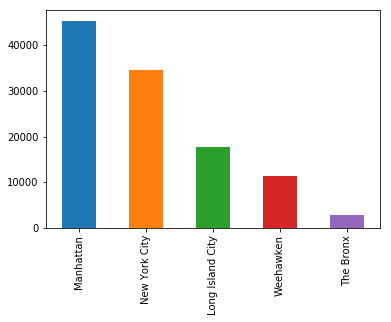

In [23]:
from collections import Counter
counts = Counter(d['pickup_district'])
counts.most_common()[:5]
d['pickup_district'].value_counts().head(5).plot.bar()

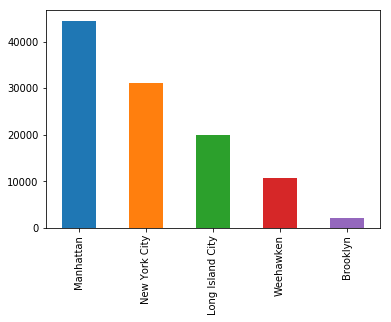

In [24]:
counts = Counter(d['dropoff_district'])
counts.most_common()[:5]
d['dropoff_district'].value_counts().head(5).plot.bar()

In [26]:
a = []
for i,j,k,l in zip(
    d.pickup_latitude,
    d.pickup_longitude, 
    d.dropoff_latitude,
    d.dropoff_longitude):
    
    a += [great_circle((i,j),(k,l)).kilometers]

d['distance'] = a

In [27]:
def dt(dtime):
    return datetime.strptime(dtime,'%Y-%m-%d %H:%M:%S')

def tod(dtime):
    if 7 <= dt(dtime).hour < 9:
        return "Rush-Hour-Morning"
    elif 9 <= dt(dtime).hour < 16:
        return "Afternoon"
    elif 16 <= dt(dtime).hour < 18:
        return "Rush-Hour-Evening"
    elif dt(dtime).hour < 23:
        return "Evening"
    else:
        return "Late-Night"
a = []
for x in d.pickup_datetime:
    a+=[tod(x)]
d['time-of-the-day'] = a

In [28]:
a = []
for x,y in zip(
    d.dropoff_datetime,
    d.pickup_datetime):
    dif = dt(x)-dt(y)
    a+=[dif.total_seconds()]
d['duration'] = a

Afternoon 	 3.1085221968242167
Late-Night 	 4.013648996044528
Evening 	 3.619583225305624
Rush-Hour-Morning 	 3.1269697354329646
Rush-Hour-Evening 	 3.3411725849919445


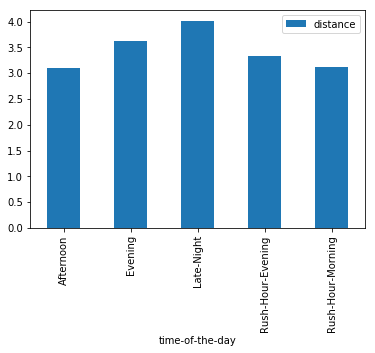

In [30]:
for t in set(d['time-of-the-day']):
    print(t,'\t',d[d['time-of-the-day']==t].distance.mean())
d[['time-of-the-day','distance']].groupby('time-of-the-day').mean().plot.bar()

Afternoon 	 963.9227460253572 seconds
Late-Night 	 912.2391106251139 seconds
Evening 	 880.0437396311115 seconds
Rush-Hour-Morning 	 918.4887158766138 seconds
Rush-Hour-Evening 	 1024.4945520581114 seconds


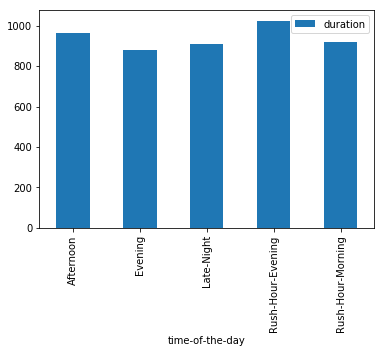

In [31]:
for t in set(d['time-of-the-day']):
    print(t,'\t',d[d['time-of-the-day']==t].duration.mean(),'seconds')
d[['time-of-the-day','duration']].groupby('time-of-the-day').mean().plot.bar()

HYPOTHESIS TESTING
--

Distance is longer for larger groups

In [38]:
onepassenger = d.passenger_count<=1;

print (d[onepassenger].duration.mean(), d[~onepassenger].duration.mean())
test = ttest(d[onepassenger].distance, d[~onepassenger].distance)

if test[1] >= 0.05:
    print ('Null Cannot Be Rejected')
else:
    print ('Reject Null Hypothesis!')

898.4021780392901 998.784384313494
Reject Null Hypothesis!


Distance is longer on weekdays

In [39]:
week_end =[] ;
week_day =[] ;

for i in d.pickup_datetime:
    week_end+=[dt(i).weekday()>4]
    week_day+=[not dt(i).weekday()>4]

print (d[week_end].duration.mean(), d[week_day].duration.mean())
test = ttest(d[week_end].distance, d[week_day].distance)

if test[1] >= 0.05:
    print ('Null Cannot Be Rejected')
else:
    print ('Reject Null Hypothesis!')

893.4216166388201 941.2284026787746
Reject Null Hypothesis!
